# Explore here


## confirming GPUs present and appear usable

In [1]:
USE_BOTH_GPUS = True

In [2]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available to Torch")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU name: {torch.cuda.get_device_name(1)}")
else:
    print("❌ GPU is NOT available to Torch")

✅ GPU is available to Torch
GPU name: NVIDIA GeForce RTX 3080 Ti
GPU name: NVIDIA GeForce RTX 3070


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.python.client import device_lib

print("🔍 TensorFlow build info:")
print(tf.sysconfig.get_build_info())

devices = device_lib.list_local_devices()
for d in devices:
    print(f"{d.name} - {d.device_type}")


2025-05-29 18:39:26.787932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748558366.910924  265980 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748558366.948016  265980 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748558367.333653  265980 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748558367.333725  265980 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748558367.333727  265980 computation_placer.cc:177] computation placer alr

🔍 TensorFlow build info:
OrderedDict([('cpu_compiler', '/usr/lib/llvm-18/bin/clang'), ('cuda_compute_capabilities', ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']), ('cuda_version', '12.5.1'), ('cudnn_version', '9'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])
/device:CPU:0 - CPU
/device:GPU:0 - GPU
/device:GPU:1 - GPU


I0000 00:00:1748558444.493709  265980 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1748558444.495568  265980 gpu_device.cc:2019] Created device /device:GPU:0 with 9446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748558444.500167  265980 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1748558444.500431  265980 gpu_device.cc:2019] Created device /device:GPU:1 with 5490 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6


In [4]:
assert tf.config.list_physical_devices("GPU"), "❌ No GPU detected by TensorFlow"

### meddling with GPU memory management settings

In [1]:
USE_BOTH_GPUS = True
USE_TENSORBOARD = True

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.keras import mixed_precision

# prevent TensorFlow from preallocating all memory up front:
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

mixed_precision.set_global_policy("mixed_float16")


2025-05-29 19:39:36.515021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748561976.900796  277941 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748561976.945376  277941 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748561977.288452  277941 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748561977.288495  277941 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748561977.288499  277941 computation_placer.cc:177] computation placer alr

Above warnings about computation placers already registered sound benign, and am ignoring warning suggesting we recompile TensorFlow with AVX2 FMA support because those sound like they'd make a bigger deal for CPU-based work, whereas am using GPUs instead.

Launch tensorboard to monitor GPU utilization.  Takes my system between 3.5 to 4 minutes to load.

In [17]:
import os
import subprocess


TENSORBOARD_LOGDIR = "logs/fit"
TENSORBOARD_SCRIPT = "/tmp/tensorboard_launcher.sh"


# When I tried doing "which tensorboard" at the terminal, or looked for its binary in .venv subfolders, I couldn't find one.
# So this fakes a startup script to a plain old python command so the normally-recommended %magics can be used.
# That startup script tends to persist through Jupyter kernel restarts, so I started adding a little more cleanup logic to this.
if USE_TENSORBOARD:
    # Ensure the launcher script exists
    if not os.path.exists(TENSORBOARD_SCRIPT):
        with open(TENSORBOARD_SCRIPT, "w") as f:
            f.write("#!/bin/bash\n")
            f.write('python -m tensorboard.main "$@"\n')
        os.chmod(TENSORBOARD_SCRIPT, 0o755)
        print(f"Created TensorBoard launcher at {TENSORBOARD_SCRIPT}")

    os.environ["TENSORBOARD_BINARY"] = TENSORBOARD_SCRIPT

    # Check if the script is already running
    result = subprocess.run(
        ["pgrep", "-af", "tensorboard"], capture_output=True, text=True
    )
    if result.stdout:
        print("TensorBoard appears to be running:\n", result.stdout)
        print("Reloading TensorBoard...")
        get_ipython().run_line_magic("reload_ext", "tensorboard")
    else:
        print("Starting new TensorBoard instance...")
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic(
            "tensorboard", f"--logdir {TENSORBOARD_LOGDIR} --port 6006"
        )
else:
    print("TensorBoard not enabled.")
    result = subprocess.run(
        ["pgrep", "-af", "tensorboard"], capture_output=True, text=True
    )
    if result.stdout:
        print("Found TensorBoard-related processes:\n", result.stdout)
        print("To stop them, run `kill PID` or `kill -9 PID` from a terminal.")
    else:
        print("No TensorBoard-related processes detected.")

Starting new TensorBoard instance...
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

## Image loading and preprocessing

In [94]:
IMAGE_SIZE = 200  # allows choosing smaller than 200 to deal with memory constraints
BATCH_SIZE = 64  # if this isn't at least 9, then a cell for sanity-checking our input data (to ensure cats and dogs are still labeled as expected) will fail
DATA_SUBSET = 25000  # in prior versions of what I'd implemented this limited to fewer than entirety of available photos for less memory & faster (albeit underfitting) training
EPOCHS = 20
TRAIN_DIR = "../data/raw/train/"
# TEST_DIR = "../data/raw/test1/" # TEST_DIR is a lie -- they were all unlabeled for competition purposes. I'll do a split of the training set below.

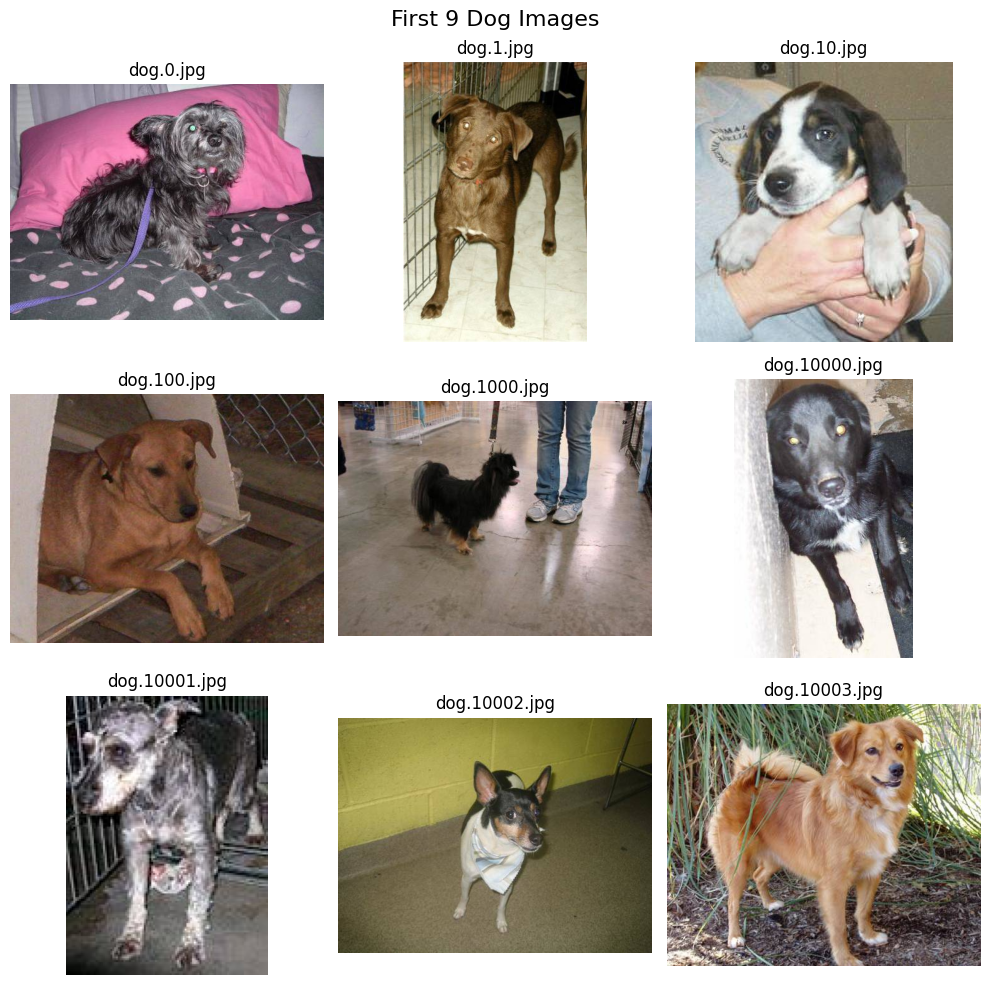

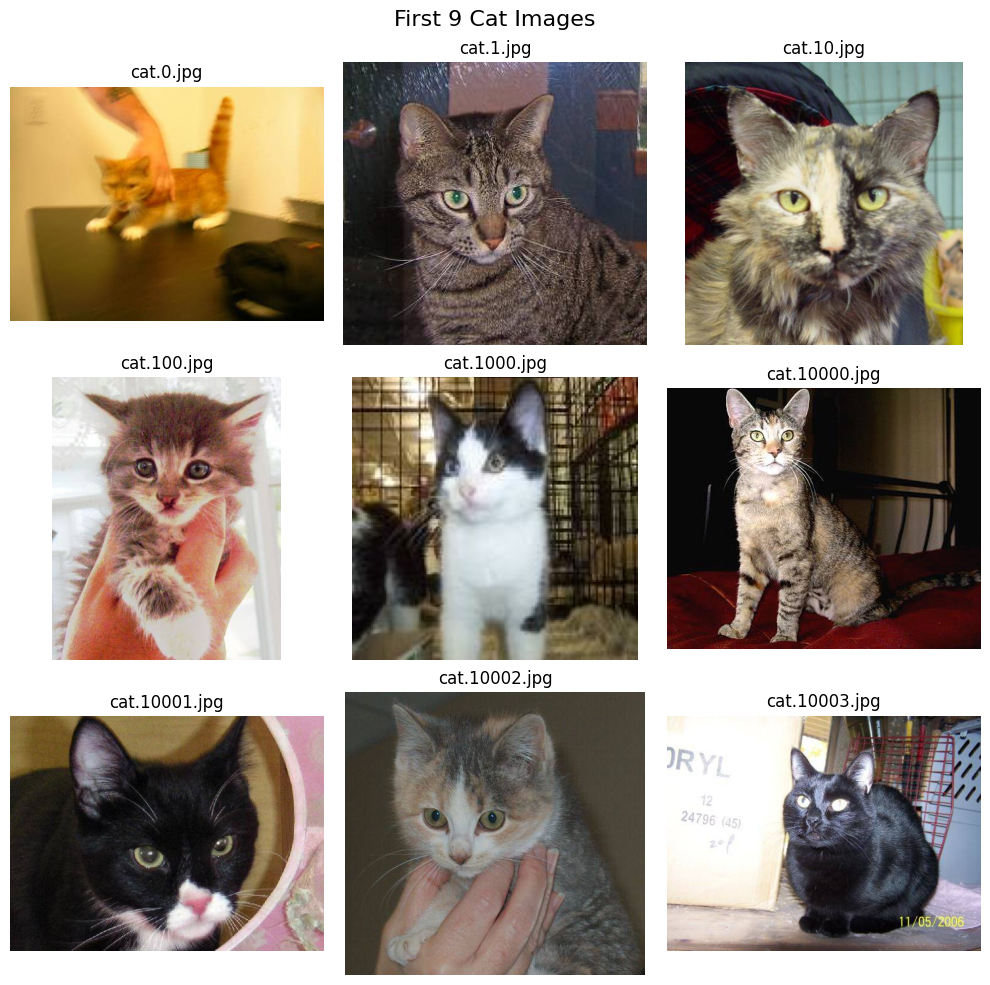

In [95]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# List first 9 dog and cat images
dog_images = sorted([f for f in os.listdir(TRAIN_DIR) if f.startswith("dog")])[:9]
cat_images = sorted([f for f in os.listdir(TRAIN_DIR) if f.startswith("cat")])[:9]


def show_images(image_filenames, title):
    plt.figure(figsize=(10, 10))
    for i, fname in enumerate(image_filenames):
        img_path = os.path.join(TRAIN_DIR, fname)
        img = mpimg.imread(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(fname)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Show first 9 dog images
show_images(dog_images, "First 9 Dog Images")

# Show first 9 cat images
show_images(cat_images, "First 9 Cat Images")


In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Collect file paths and infer labels
filepaths = sorted([os.path.join(TRAIN_DIR, fname) for fname in os.listdir(TRAIN_DIR)])

# keep as strings instead of one-hot encoding yet because flow_from_dataframe will expect that for categorical class mode
labels = ["dog" if "dog" in fname else "cat" for fname in filepaths]

# Create DataFrame
df = pd.DataFrame({"filename": filepaths, "label": labels})

effective_subset_size = min(
    DATA_SUBSET, len(df) - 2
)  # because we wouldn't want to accidentally attempt working with more files than we really found

# Sample a balanced subset
df_subset, _ = train_test_split(
    df,
    train_size=effective_subset_size,
    stratify=df["label"],
    random_state=42,
)

# Split into train and validation sets. Stratify to ensure enough dogs and cats in each set.
train_df, valid_df = train_test_split(
    df_subset, test_size=0.2, stratify=df_subset["label"], random_state=42
)


Anytime batch size is changed to try to tweak performance & notebook run duration, should rerun these trdata an tsdata construction cells:

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# Use flow_from_dataframe
trdata = datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

tsdata = datagen.flow_from_dataframe(
    valid_df,
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### checking balance between cats vs. dogs in either set

In [100]:
import numpy as np

# Training data stats
print("Training batch class indices:", trdata.class_indices)
print("Training samples:", trdata.samples)
train_class_counts = np.bincount(trdata.labels)
print("Training class distribution:")
for class_label, count in zip(trdata.class_indices, train_class_counts):
    print(f"  {class_label}: {count} samples")

# Validation data stats
print("Validation samples:", tsdata.samples)
val_class_counts = np.bincount(tsdata.labels)
print("Validation class distribution:")
for class_label, count in zip(tsdata.class_indices, val_class_counts):
    print(f"  {class_label}: {count} samples")


Training batch class indices: {'cat': 0, 'dog': 1}
Training samples: 19998
Training class distribution:
  cat: 9999 samples
  dog: 9999 samples
Validation samples: 5000
Validation class distribution:
  cat: 2500 samples
  dog: 2500 samples


Diagnostic cell to check whether or not I shuffled something around on accident and disassociated proper labels from their images:

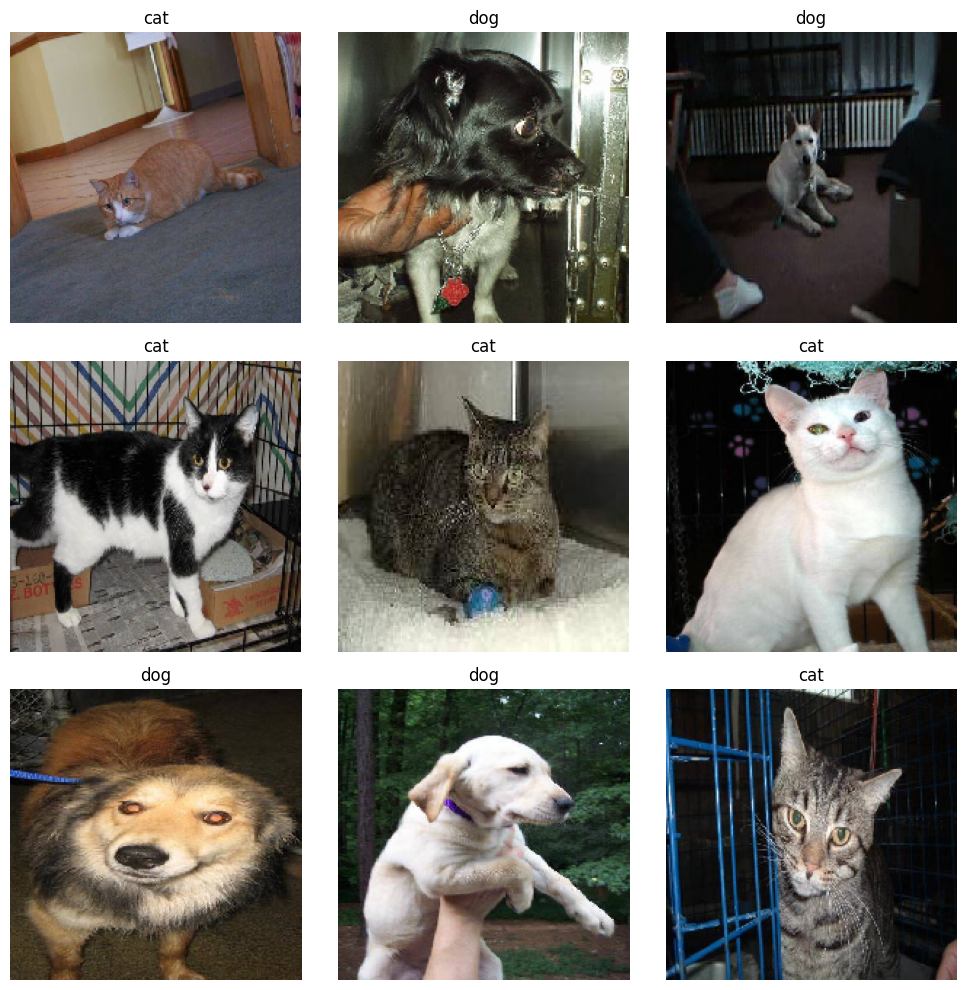

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the training generator
images, labels = next(trdata)

# Map class indices back to labels
class_indices = {v: k for k, v in trdata.class_indices.items()}
decoded_labels = [class_indices[np.argmax(label)] for label in labels]

# Plot the first 9 images with labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(decoded_labels[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


## VGG16-BN variant
using this instead of something closer to original VGG-16 because after I read about BatchNormalization and GlobalAveragePooling2D I found adding them in helped with my memory constraints

In [111]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    GlobalAveragePooling2D,
    Dense,
    Input,
    BatchNormalization,
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def multiplier(input: int, depth_multiplier: int = 0) -> int:
    """Calculation is simple, but this Helps ensure we're feeding ints instead of floats to these layer parameters, and makes it easier to keep layers relatively scaled among each other"""
    return int(input * depth_multiplier)


DEPTH_MULTIPLIER = (
    2  # to imitate VGG, use a multiplier value of 8...but beware memory constraints.
)

# Build the model inline
model = Sequential(
    [
        Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        # First conv block
        Conv2D(
            multiplier(8, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(8, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        # Second conv block
        Conv2D(
            multiplier(16, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(16, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        # Third conv block
        Conv2D(
            multiplier(32, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(32, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(32, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        # fourth conv block
        Conv2D(
            multiplier(64, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(64, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(64, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        # fifth conv block
        Conv2D(
            multiplier(128, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(128, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            multiplier(128, DEPTH_MULTIPLIER), (3, 3), activation="relu", padding="same"
        ),
        BatchNormalization(),
        # after conv blocks
        MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D(),  # reduces number of parameters vs. Flatten(), helping keep under my available memory limits
        Dense(multiplier(512, DEPTH_MULTIPLIER), activation="relu"),
        Dense(2, activation="softmax"),
    ]
)

# Compile it
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [112]:
# callbacks for use during training


class GPUMemoryLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        for i, gpu in enumerate(tf.config.list_physical_devices("GPU")):
            mem = tf.config.experimental.get_memory_info(f"GPU:{i}")
            print(
                f"[Epoch {epoch + 1}] GPU {i} - Used: {mem['current'] // 1e6} MB, Peak: {mem['peak'] // 1e6} MB"
            )


checkpoint_cb = ModelCheckpoint(
    "checkpoints/best_model.keras",  # Filepath to save the best model
    save_best_only=True,  # Only save if val_loss improves
    monitor="val_loss",  # Quantity to monitor
    mode="min",  # Lower val_loss is better
    verbose=1,  # Print messages on saving
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",  # Stop if no improvement in val_loss
    patience=5,  # Allow 5 epochs without improvement
    restore_best_weights=True,  # Roll back to best weights on stop
    verbose=1,
)


In [113]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Create a log directory with a timestamp
log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Record activation histograms every epoch
    write_graph=True,  # Log model graph
    write_images=True,  # Log weight images
)

In [114]:
# Train it
history = model.fit(
    trdata,
    validation_data=tsdata,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, tensorboard_cb, GPUMemoryLogger()],
)

Epoch 1/20


2025-05-29 21:47:22.914774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3135', 16 bytes spill stores, 16 bytes spill loads



249/313 ━━━━━━━━━━━━━━━━━━━━ 35s 548ms/step - accuracy: 0.6486 - loss: 0.6264

2025-05-29 21:50:07.508590: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3135', 40 bytes spill stores, 40 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.6581 - loss: 0.6158

2025-05-29 21:51:04.469722: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_478', 12 bytes spill stores, 12 bytes spill loads

2025-05-29 21:51:05.089204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_487', 4 bytes spill stores, 4 bytes spill loads

2025-05-29 21:51:05.489975: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_487', 8 bytes spill stores, 8 bytes spill loads

2025-05-29 21:51:07.144821: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_487', 248 bytes spill stores, 248 bytes spill loads

2025-05-29 21:51:07.602496: I external/local_x


Epoch 1: val_loss improved from inf to 1.23467, saving model to checkpoints/best_model.keras
[Epoch 1] GPU 0 - Used: 132.0 MB, Peak: 2224.0 MB
[Epoch 1] GPU 1 - Used: 0.0 MB, Peak: 0.0 MB
313/313 ━━━━━━━━━━━━━━━━━━━━ 344s 926ms/step - accuracy: 0.6582 - loss: 0.6156 - val_accuracy: 0.5002 - val_loss: 1.2347
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7962 - loss: 0.4365
Epoch 2: val_loss improved from 1.23467 to 0.41995, saving model to checkpoints/best_model.keras
[Epoch 2] GPU 0 - Used: 132.0 MB, Peak: 2224.0 MB
[Epoch 2] GPU 1 - Used: 0.0 MB, Peak: 0.0 MB
313/313 ━━━━━━━━━━━━━━━━━━━━ 211s 670ms/step - accuracy: 0.7962 - loss: 0.4364 - val_accuracy: 0.8064 - val_loss: 0.4200
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8538 - loss: 0.3357
Epoch 3: val_loss improved from 0.41995 to 0.35822, saving model to checkpoints/best_model.keras
[Epoch 3] GPU 0 - Used: 132.0 MB, Peak: 2224.0 MB
[Epoch 3] GPU 1 - Used: 0.0 MB, Peak: 0.0 MB
313/313 ━

### Evaluating model

In [115]:
from tensorflow.keras.models import load_model

best_model = load_model("checkpoints/best_model.keras")
results = best_model.evaluate(tsdata)
print(f"Validation accuracy: {results[1]:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 462ms/step - accuracy: 0.8625 - loss: 0.3238
Validation accuracy: 0.8576


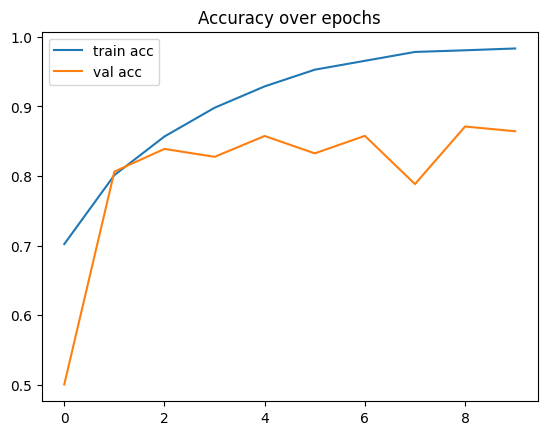

In [116]:
# visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()

Self-reminder: if accuracy rises while val_accuracy plateaus or drops, at least beyond a minor gap, that's a sign of overfitting.

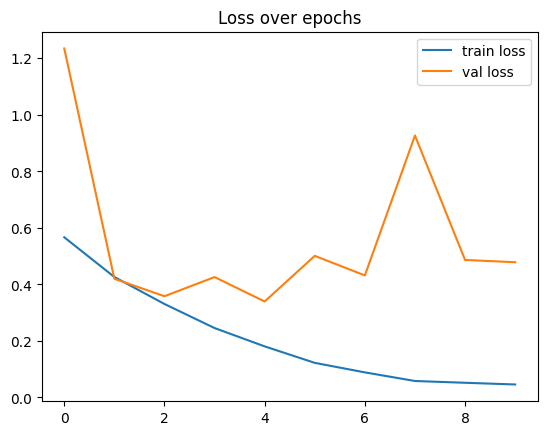

In [117]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

Self-reminder: if val_loss increases while loss decreases, that's a sign of overfitting

# more recent models besides VGG-16 to maybe toy with later

In [118]:
from tensorflow.keras.layers import Add, Activation


def resnet_block(input_tensor, filters):
    x = Conv2D(filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)

    # Add skip connection
    x = Add()([x, input_tensor])
    x = Activation("relu")(x)
    return x


In [119]:
from tensorflow.keras.layers import Concatenate


def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        out = BatchNormalization()(x)
        out = Activation("relu")(out)
        out = Conv2D(growth_rate, (3, 3), padding="same")(out)
        x = Concatenate()([x, out])
    return x
